In [8]:
import numpy as np
import scipy as sp
from matplotlib  import pyplot as plt
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torch.nn import MSELoss

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from tqdm.notebook import tqdm

import os
import shutil
torch.cuda.empty_cache()

# from subset_select_ipot import subset_select_ipot as ss_ipot
# from subset_select_FISTA import subset_select_FISTA as ss
from subset_select_non_uniform_entropic_FISTA_git import subset_select_non_uniform_FISTA as ss
from subset_select_ipot_non_uniform_git import subset_select_ipot as ss_ipot

2D Subset Selection

In [9]:
torch.manual_seed(1)
d = 2
n = 256
Z = torch.rand([n, d]) - 0.5
sign_z = torch.sign(Z)
sigma_z = torch.all((sign_z == -1), dim=1)
X = Z[~sigma_z]
X = X + 1*torch.sign(X)

# Y = X + 5
Z1 = torch.rand([n, d]) - 0.5
Y = Z1 + 1*torch.sign(Z1) + 5


# d = 2
# n = 256
# Z = torch.rand([n, d]) - 0.5
# sign_z = torch.sign(Z)
# sigma_z = torch.all((sign_z == -1), dim=1)
# X = Z[~sigma_z]
# X = X + 1*torch.sign(X)

# # Y = X + 5
# Z1 = torch.rand([n, d]) - 0.5
# Y = 2*(Z1 + 1*torch.sign(Z1)) + 5


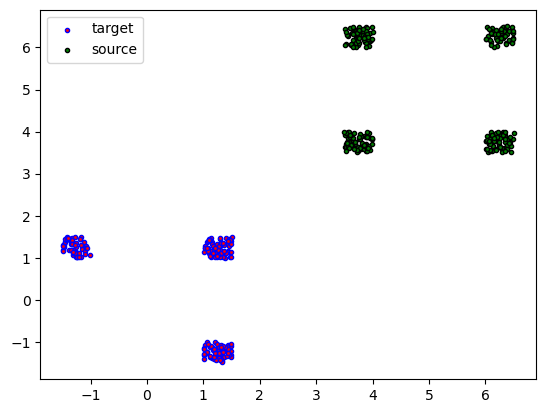

In [10]:
plt.scatter(X.T[0], X.T[1], marker='.',facecolor='r', edgecolors='b', label="target")
plt.scatter(Y.T[0], Y.T[1], marker='.',facecolor='g', edgecolors='k', label="source")
plt.legend()



In [10]:
name_core = "\\SS\\Results\\d={0}\\".format(d)

if os.path.exists(name_core):
    shutil.rmtree(name_core)
os.makedirs(name_core)

In [13]:
torch.manual_seed(1)
max_epochs = 500
ss_max_iter = 2000
wd = 2
gamma = 0.01

# Lts = [1, 0.125*Y.shape[0], 0.25*Y.shape[0], 0.875*Y.shape[0], 0.50*Y.shape[0], 0.625*Y.shape[0], 0.75*Y.shape[0], 0.875*Y.shape[0], Y.shape[0]]
cs = [1, 1.25, 1.50, 1.75, 2, 4, 8, 16]
X = X.to(device)
Y = Y.to(device)


class AffineNet(nn.Module):
    def __init__(self, i_dim):
        super(AffineNet, self).__init__()
        self.A = nn.parameter.Parameter(
            torch.eye(i_dim, dtype=torch.float32, requires_grad=True))
        self.b = nn.parameter.Parameter(torch.zeros(
            [1, i_dim], dtype=torch.float32, requires_grad=True))

    def forward(self, Y):
        return torch.mm(Y, self.A) + self.b


# Affine_MAP = AffineNet(2).to(device)
# adam = torch.optim.Adam(Affine_MAP.parameters(), lr=0.1,
#                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0)



for c in cs:
    costs = []
    Affine_MAP = AffineNet(d).to(device)
    adam = torch.optim.Adam(Affine_MAP.parameters(), lr=0.5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    print("c=",c)
    for epoch in range(0, max_epochs):
        adam.zero_grad()
        Y_transfomed = Affine_MAP(Y)
        C = torch.norm(X[:, None, :] - Y_transfomed, dim=2, p=2)**wd
        mu = np.ones([X.shape[0], 1])/X.shape[0]
        nu = np.ones([Y.shape[0], 1])/Y.shape[0]
        
        M = C.detach().cpu().numpy()
        M = M/np.max(M)
        K = np.exp(-M/gamma)
        # subset_select_non_uniform_FISTA(mu, nu, c, K, M, gamma=1e-1, Lt=1e-1, eta = 1.1, max_iter = 20000, back_tracking = False, disp_iter=False):
        P, _, _, _ = ss(mu, nu, c, K, M, gamma=gamma, Lt=1/gamma, max_iter=ss_max_iter,  disp_iter=False)
        # _, P = ss_ipot(X.detach().cpu().numpy(), Y_transfomed.detach().cpu().numpy(), mu, gamma, L=L, max_outer_iter=max_outer_iter,
        #                max_inner_iter=max_inner_iter, wd=wd, disp_iter=False, return_map=True)
        P = torch.tensor(P, dtype=torch.double, device=device, requires_grad=False)
        # print(P.shape)
        cost = torch.sum(P*C)
        cost.backward()
        adam.step()
        costs.append(cost.item())
        print(f'Epoch {epoch} Loss {cost.item():.4f}')
    
    path = name_core + "d="+ str(d) + "c=" + str(c)+".pth"
    torch.save({'AM_infer': Affine_MAP.state_dict(), "costs":costs}, path)

c= 1
Epoch 0 Loss 42.0101
Epoch 1 Loss 2.9262
Epoch 2 Loss 28.3487
Epoch 3 Loss 21.0508
Epoch 4 Loss 4.3811
Epoch 5 Loss 2.2694
Epoch 6 Loss 11.4867
Epoch 7 Loss 14.8432
Epoch 8 Loss 8.7588
Epoch 9 Loss 2.0406
Epoch 10 Loss 1.7203
Epoch 11 Loss 5.9822
Epoch 12 Loss 8.5967
Epoch 13 Loss 6.6148
Epoch 14 Loss 2.7664
Epoch 15 Loss 0.9666
Epoch 16 Loss 2.5797
Epoch 17 Loss 4.9036
Epoch 18 Loss 4.9457
Epoch 19 Loss 2.8530
Epoch 20 Loss 1.1057
Epoch 21 Loss 1.3858
Epoch 22 Loss 2.8316
Epoch 23 Loss 3.4757
Epoch 24 Loss 2.6760
Epoch 25 Loss 1.3724
Epoch 26 Loss 0.9999
Epoch 27 Loss 1.7337
Epoch 28 Loss 2.4145
Epoch 29 Loss 2.1465
Epoch 30 Loss 1.3291
Epoch 31 Loss 0.9650
Epoch 32 Loss 1.3525
Epoch 33 Loss 1.8245
Epoch 34 Loss 1.7297
Epoch 35 Loss 1.2267
Epoch 36 Loss 0.9639
Epoch 37 Loss 1.1873
Epoch 38 Loss 1.4814
Epoch 39 Loss 1.4107
Epoch 40 Loss 1.0959
Epoch 41 Loss 0.9648
Epoch 42 Loss 1.1343
Epoch 43 Loss 1.2988
Epoch 44 Loss 1.2115
Epoch 45 Loss 1.0130
Epoch 46 Loss 0.9756
Epoch 47 Loss

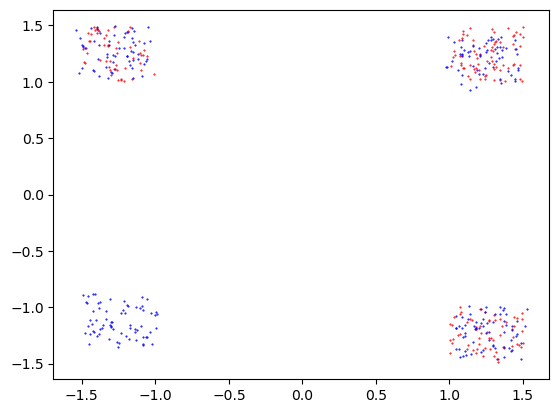

In [14]:
Affine_MAP.eval()
Yt = Affine_MAP(Y).detach().cpu().numpy()
Xt = X.detach().cpu().numpy()
plt.scatter(Xt[:, 0], Xt[:, 1], s=1, marker='.',
                      facecolor='r', edgecolors='r')

plt.scatter(Yt[:, 0], Yt[:, 1], s=1, marker='.',
                      facecolor='b', edgecolors='b')


In [15]:
for params in Affine_MAP.parameters():
    print(params)


Parameter containing:
tensor([[ 1.0056, -0.0399],
        [-0.0217,  0.9546]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-4.9228, -4.5563]], device='cuda:0', requires_grad=True)


In [11]:
name_core = name_core = "\\SS-ipot\\Results\\d={0}\\".format(d)
if os.path.exists(name_core):
    shutil.rmtree(name_core)
os.makedirs(name_core)

In [20]:
torch.manual_seed(1)

max_outer_iter = 100
max_inner_iter = 500
max_epochs = 500
gamma = 0.01
wd = 2

# Lts = [1, 0.125*Y.shape[0], 0.25*Y.shape[0], 0.375*Y.shape[0], 0.50*Y.shape[0], 0.625*Y.shape[0], 0.75*Y.shape[0], 0.875*Y.shape[0], Y.shape[0]]
cs = [1, 1.25, 1.50, 1.75, 2, 4, 8, 16]
X = X.to(device)
Y = Y.to(device)

class AffineNet(nn.Module):
    def __init__(self, i_dim):
        super(AffineNet, self).__init__()
        self.A = nn.parameter.Parameter(
            torch.eye(i_dim, dtype=torch.double, requires_grad=True))
        self.b = nn.parameter.Parameter(torch.zeros(
            [1, i_dim], dtype=torch.double, requires_grad=True))

    def forward(self, Y):
        return torch.mm(Y, self.A) + self.b


# Affine_MAP = AffineNet(2).to(device)
# adam = torch.optim.Adam(Affine_MAP.parameters(), lr=1,
#                         betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# if cost.detach().item() < cost_best:
#                 cost_best = cost.detach().item()
#                 AM_infer = AffineMap().to(device)
#                 AM_infer.load_state_dict(AM.state_dict())

#     path = name_core + "L=" + str(Lt)+".pth"
#     torch.save({'AM_infer': AM_infer.state_dict(), "costs":costs}, path)

for c in cs:
    costs = []
    Affine_MAP = AffineNet(d).to(device)
    adam = torch.optim.Adam(Affine_MAP.parameters(), lr=0.5, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
    print("c=", c)
    for epoch in range(0, max_epochs):
        adam.zero_grad()
        Y_transfomed = Affine_MAP(Y)
        C = torch.norm(X[:, None, :] - Y_transfomed, dim=2, p=2)**wd
        mu = np.ones([X.shape[0], 1])/X.shape[0]
        nu = np.ones([Y.shape[0],1])/Y.shape[0]
        
        _, P, _, _ = ss_ipot(X.detach().cpu().numpy(), Y_transfomed.detach().cpu().numpy(), mu, nu, c, gamma, max_outer_iter=max_outer_iter, return_map=True)
        
        # subset_select_ipot(X, Y, mu, nu, c,  gamma, max_outer_iter, max_inner_iter = 20 , wd = 2, disp_iter = False, return_map = False)
        
        P = torch.tensor(P, dtype=torch.double, device=device, requires_grad=False)
        # print(P.shape)
        cost = torch.sum(P*C)
        cost.backward()
        adam.step()
        costs.append(cost.item())
        print(f'Epoch {epoch} Loss {cost.item():.4f}')
    
    path = name_core + "d="+ str(d) + "c=" + str(c)+".pth"
    torch.save({'AM_infer': Affine_MAP.state_dict(), "costs":costs}, path)

c= 1
Epoch 0 Loss 35.3386
Epoch 1 Loss 2.6388
Epoch 2 Loss 21.9945
Epoch 3 Loss 15.7707
Epoch 4 Loss 3.0961
Epoch 5 Loss 2.7770
Epoch 6 Loss 10.1248
Epoch 7 Loss 11.2055
Epoch 8 Loss 5.8995
Epoch 9 Loss 1.0176
Epoch 10 Loss 2.6163
Epoch 11 Loss 6.1328
Epoch 12 Loss 6.8010
Epoch 13 Loss 4.0859
Epoch 14 Loss 1.2258
Epoch 15 Loss 1.2644
Epoch 16 Loss 3.6013
Epoch 17 Loss 4.4636
Epoch 18 Loss 2.7723
Epoch 19 Loss 0.9738
Epoch 20 Loss 1.0939
Epoch 21 Loss 2.4935
Epoch 22 Loss 2.6384
Epoch 23 Loss 1.9452
Epoch 24 Loss 0.8861
Epoch 25 Loss 0.9275
Epoch 26 Loss 1.7293
Epoch 27 Loss 1.9927
Epoch 28 Loss 1.3568
Epoch 29 Loss 0.7980
Epoch 30 Loss 0.9236
Epoch 31 Loss 1.4290
Epoch 32 Loss 1.4379
Epoch 33 Loss 1.0025
Epoch 34 Loss 0.7399
Epoch 35 Loss 0.9685
Epoch 36 Loss 1.2261
Epoch 37 Loss 1.0604
Epoch 38 Loss 0.7774
Epoch 39 Loss 0.7579
Epoch 40 Loss 0.9952
Epoch 41 Loss 0.9892
Epoch 42 Loss 0.7586
Epoch 43 Loss 0.7465
Epoch 44 Loss 0.8887
Epoch 45 Loss 0.9305
Epoch 46 Loss 0.8122
Epoch 47 Loss

In [18]:
Y.device

device(type='cpu')